In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 「打率.250 40HR」打線VS「打率.330 5HR」打線
やきうのおじいさんのツイートに触発されて作ってみました。ツイート：https://twitter.com/yakiunoojisan/status/1097035372008071168

マルコフ過程に基づくモデルで得点分布を作成しました。モデルについてはhttps://github.com/Toroi0610/Baseball/blob/master/Markov_process.ipynb

## 「打率.250 40HR」打線
1985年の秋山幸二選手が成績的にもちょうど良いかなと思います。

In [2]:
folder = "data_csv/batting_number_data/"
koji_akiyama_dasen = pd.read_csv(folder+"koji_akiyama.csv", index_col="INDEX")
koji_akiyama_dasen.head(10)

,AVE,RBI,HR,H,SIN,DOU,TRI,OBP,SLG,OPS,...,AB,R,BB,HBP,SB,SH,SF,DP,EOB,K
INDEX,,,,,,,,,,,,,,,,,,,,,
NO1,0.252,93,40,118,62,16,0,0.348,0.543,0.89,...,468,93,66,4,17,1,3,13,0,115
NO2,0.252,93,40,118,62,16,0,0.348,0.543,0.89,...,468,93,66,4,17,1,3,13,0,115
NO3,0.252,93,40,118,62,16,0,0.348,0.543,0.89,...,468,93,66,4,17,1,3,13,0,115
NO4,0.252,93,40,118,62,16,0,0.348,0.543,0.89,...,468,93,66,4,17,1,3,13,0,115
NO5,0.252,93,40,118,62,16,0,0.348,0.543,0.89,...,468,93,66,4,17,1,3,13,0,115
NO6,0.252,93,40,118,62,16,0,0.348,0.543,0.89,...,468,93,66,4,17,1,3,13,0,115
NO7,0.252,93,40,118,62,16,0,0.348,0.543,0.89,...,468,93,66,4,17,1,3,13,0,115
NO8,0.252,93,40,118,62,16,0,0.348,0.543,0.89,...,468,93,66,4,17,1,3,13,0,115
NO9,0.252,93,40,118,62,16,0,0.348,0.543,0.89,...,468,93,66,4,17,1,3,13,0,115


## 「打率.330 5HR」打線
2018年の平田選手の成績を用います．

In [3]:
ryosuke_hirata_dasen = pd.read_csv(folder+"ryosuke_hirata.csv", index_col="INDEX")
ryosuke_hirata_dasen.head(10)

,AVE,RBI,HR,H,SIN,DOU,TRI,OBP,SLG,OPS,...,AB,R,BB,HBP,SB,SH,SF,DP,EOB,K
INDEX,,,,,,,,,,,,,,,,,,,,,
NO1,0.329,55,9,162,122,26,5,0.41,0.456,0.866,...,493,83,67,3,8,2,3,7,0,69
NO2,0.329,55,9,162,122,26,5,0.41,0.456,0.866,...,493,83,67,3,8,2,3,7,0,69
NO3,0.329,55,9,162,122,26,5,0.41,0.456,0.866,...,493,83,67,3,8,2,3,7,0,69
NO4,0.329,55,9,162,122,26,5,0.41,0.456,0.866,...,493,83,67,3,8,2,3,7,0,69
NO5,0.329,55,9,162,122,26,5,0.41,0.456,0.866,...,493,83,67,3,8,2,3,7,0,69
NO6,0.329,55,9,162,122,26,5,0.41,0.456,0.866,...,493,83,67,3,8,2,3,7,0,69
NO7,0.329,55,9,162,122,26,5,0.41,0.456,0.866,...,493,83,67,3,8,2,3,7,0,69
NO8,0.329,55,9,162,122,26,5,0.41,0.456,0.866,...,493,83,67,3,8,2,3,7,0,69
NO9,0.329,55,9,162,122,26,5,0.41,0.456,0.866,...,493,83,67,3,8,2,3,7,0,69


In [4]:
def make_prob_matrix_runner_condition(table, runner_condition_table):
    """
    ---------
    input
    ---------
    table・・・9人分の選手の成績が入ったPandas.DataFrameのデータ
    runner_condition_table・・・状況と結果から状態遷移する確率を計算する．
    
    ---------
    output
    ---------
    P・・・選手数 9 * 現在の状態 25 * 次の時刻での状態 25
    """

    PA = table["PA"].values - table["EOB"].values
    dou = table["DOU"].values
    tri = table["TRI"].values
    hom = table["HR"].values
    wal = table["BB"].values + table["HBP"].values
    sin = table["H"].values - dou - tri - hom
    sh = table["SH"].values
    sf = table["SF"].values


    pw = wal / PA # 式(4)
    ps = sin / PA # 式(5)
    pd = dou / PA # 式(6)
    pt = tri / PA # 式(7)
    ph = hom / PA # 式(8)
    psh = sh / PA # 式(9)
    psf = sf / PA # 式(10)

    po = 1 - pw - ps - pd - pt - ph - psh - psf # 式(11)

    alpha = np.zeros([24, 24], dtype="float")
    for index, row in runner_condition_table.iterrows():
        alpha[row["current_situation"], row["Next_situation_1"]] = row["percent_1"]
        alpha[row["current_situation"], row["Next_situation_2"]] = row["percent_2"]
        try:
            alpha[row["current_situation"], int(row["Next_situation_3"])] = row["percent_3"]
        except:
            pass

    P = np.zeros([9, 25, 25])

    # 式(36, 37, 38)
    A = np.zeros([3, 8, 8])

    for i in range(9):
        
        for j in range(3):

            # 式(36, 37, 38)
            A[j] = np.array([[ph[i], ps[i]+pw[i], pd[i], pt[i], 0, 0, 0, 0],
                             [ph[i], 0, alpha[1 + 8 * j, 2 + 8 * j] * pd[i], pt[i], alpha[1 + 8 * j, 4 + 8 * j] * ps[i]+pw[i], alpha[1 + 8 * j, 5 + 8 * j] * ps[i], alpha[1 + 8 * j, 6 + 8 * j] * pd[i], 0],
                             [ph[i], alpha[2 + 8 * j, 1 + 8 * j] * ps[i], pd[i], pt[i], pw[i], alpha[2 + 8 * j, 5 + 8 * j] * ps[i], 0, 0],
                             [ph[i], ps[i], pd[i], pt[i], 0, pw[i], 0, 0],
                             [ph[i], 0, alpha[4 + 8 * j, 2 + 8 * j] * pd[i], pt[i], alpha[4 + 8 * j, 4 + 8 * j] * ps[i], alpha[4 + 8 * j, 5 + 8 * j] * ps[i], alpha[4 + 8 * j, 6 + 8 * j] * pd[i], alpha[4 + 8 * j, 7 + 8 * j] * ps[i] + pw[i]],
                             [ph[i], 0, alpha[5 + 8 * j, 2 + 8 * j] * pd[i], pt[i], alpha[5 + 8 * j, 4 + 8 * j] * ps[i], alpha[5 + 8 * j, 5 + 8 * j] * ps[i], alpha[5 + 8 * j, 6 + 8 * j] * pd[i], pw[i]],
                             [ph[i], alpha[6 + 8 * j, 1 + 8 * j] * ps[i], pd[i], pt[i], 0, alpha[6 + 8 * j, 5 + 8 * j] * ps[i], 0, pw[i]],
                             [ph[i], 0, 0, pt[i], alpha[7 + 8 * j, 4 + 8 * j] * ps[i], alpha[7 + 8 * j, 5 + 8 * j] * ps[i], pd[i], alpha[7 + 8 * j, 7 + 8 * j] * ps[i] + pw[i]]])

        # 式(14)
        B = np.identity(8) * (po[i] + psh[i])
        # 式(15)
        F = np.ones([8]) * (po[i] + psh[i] + psf[i])

        P[i, :8, :8] = A[0]
        P[i, :8, 8:16] = B
        P[i, 8:16, 8:16] = A[1]
        P[i, 8:16, 16:24] = B
        P[i, 16:24, 16:24] = A[2]
        P[i, 16:24, 24] = F
        P[i, 24, 24] = 1

        P[i, 1, 10] = psh[i]
        P[i, 2, 11] = psf[i]
        P[i, 3, 8] = psf[i]
        P[i, 4, 13] = psf[i]
        P[i, 5, 9] = psf[i]
        P[i, 6, 11] = psf[i]
        P[i, 7, 13] = psf[i]
        P[i, 9, 18] = psh[i]
        P[i, 10, 19] = psf[i]
        P[i, 11, 16] = psf[i]
        P[i, 12, 21] = psf[i]
        P[i, 13, 17] = psf[i]
        P[i, 14, 19] = psf[i]
        P[i, 15, 21] = psf[i]

        P[i, 0, 8] += psf[i]
        P[i, 8, 16] += psf[i]
        P[i, 1, 9] += psf[i] - psh[i]
        P[i, 9, 17] += psf[i] - psh[i]

    return P


def Run_matrix(Prob, R_max, start_number, end_prob):
    mask_A = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                       [2, 1, 1, 1, 0, 0, 0, 0],
                       [2, 1, 1, 1, 0, 0, 0, 0],
                       [2, 1, 1, 1, 0, 0, 0, 0],
                       [3, 2, 2, 2, 1, 1, 1, 0],
                       [3, 2, 2, 2, 1, 1, 1, 0],
                       [3, 2, 2, 2, 1, 1, 1, 0],
                       [4, 3, 3, 3, 2, 2, 2, 1]])


    mask_matrix = np.zeros([25, 25])
    mask_matrix[:8, :8] = mask_A
    mask_matrix[8:16, 8:16] = mask_A
    mask_matrix[16:24, 16:24] = mask_A



    #犠飛を考える
    mask_matrix[3, 8] = 1
    mask_matrix[5, 9] = 1
    mask_matrix[6, 11] = 1
    mask_matrix[7, 13] = 1
    mask_matrix[11, 16] = 1
    mask_matrix[13, 17] = 1
    mask_matrix[14, 19] = 1
    mask_matrix[15, 21] = 1


    P = np.zeros([5, 9, 25, 25])
    for i in range(5):
        P[i] = Prob * [mask_matrix==i]
    U = np.zeros([R_max, 25])
    U[0, 0] = 1
    k = start_number
    E = np.zeros([9, R_max])
    #i = 0
    t = 0
    while np.sum(U[:, 24]) <= end_prob:
        #print(i)
        #i += 1
        #式(2)
        U_pre = np.copy(U)
        U = np.dot(U_pre , P[0, k])
        for r in range(1,5):
            U[r:] += np.dot(U_pre[:-r], P[r, k])

        b = U[:, 24] - U_pre[:, 24]

        #次の打者に動く
        k += 1
        k = k % 9

        for r in range(R_max):
            E[k,r] += b[r]

        #print(np.sum(U[:, 24]))
        """
        if np.sum(b) <= 0.0 and i > 2:
            t += 1
            U = np.zeros([R_max + t, 25])
            U[0,0] = 1
            k = start_number
            E = np.zeros([9,R_max + t])
            i = 0
        """


    return E, t


def cal_ERBG(Prob, R_max, end_prob):
    E = []
    t = 0
    for i in range(9):
#        print (i)
        a, t = Run_matrix(Prob, R_max + t, i, end_prob)
        E.append(a)

    val = E[-1].shape[1]
    for i in range(9):
        k = val - E[i].shape[1]
        E[i] = np.c_[E[i], np.zeros([k, 9]).T]

    E = np.array(E)

    A = np.zeros([10, 9, val])
    A[0, 0, 0] = 1
    for m in range(1, 10):
        for r in range(val):
            for l in range(r+1):
                A[m, :, r] += np.dot(A[m-1, :,r-l], E[:, :, l])
    """
    シグマ計算記述用
    for m in range(1,10):
        for n in range(9):
            for r in range(val):
                for l in range(r+1):
                    A[m,n,r] += np.dot(A[m-1,:,r-l],E[:,:,l])
    """
    Run_prob = np.sum(A[9], axis=0)
    ERBG = np.sum(Run_prob * np.arange(val))

    """
    できばえ確認用
    plt.plot(Run_prob)
    print(ERBG)
    """

    return ERBG, Run_prob


In [5]:
# 2018年度NPBの走塁状況
runner_condition_table = pd.read_csv("NPB_runner_condition_and_results_data_2018.csv")

# 式(30)のR_max
R_max = 35

# 計算を終える状態24の確率
end_prob = 1 - 1e-6

ERBGs = []
Run_probs = []
for table in [koji_akiyama_dasen, ryosuke_hirata_dasen]:
    # 式(3)のP
    P = make_prob_matrix_runner_condition(table, runner_condition_table)

    # 得点期待値と得点の確率分布
    ERBG, Run_prob = cal_ERBG(P, R_max, end_prob)
    
    ERBGs.append(ERBG)
    Run_probs.append(Run_prob)
    
Run_probs = np.array(Run_probs)
ERBGs = np.array(ERBGs)

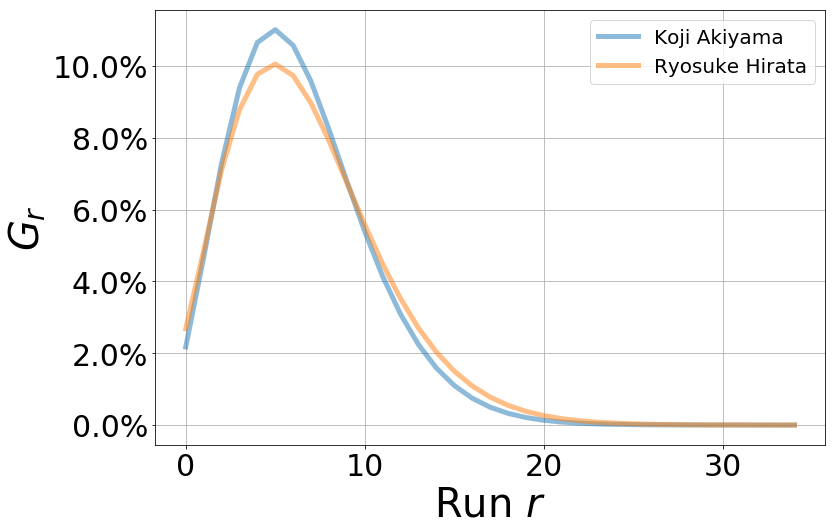

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(np.arange(0, R_max), Run_probs[0], label="Koji Akiyama", linewidth=5, alpha=0.5)
ax.plot(np.arange(0, R_max), Run_probs[1], label="Ryosuke Hirata", linewidth=5, alpha=0.5)
ax.legend(fontsize=20)
ax.tick_params(labelsize=30)
ax.grid()
ax.set_xlabel("Run $r$", fontsize=40)
ax.set_ylabel("$G_r$", fontsize=40)
ax.set_yticklabels(['{:.{}f}%'.format(x*100, 1) for x in ax.get_yticks()])
plt.show()

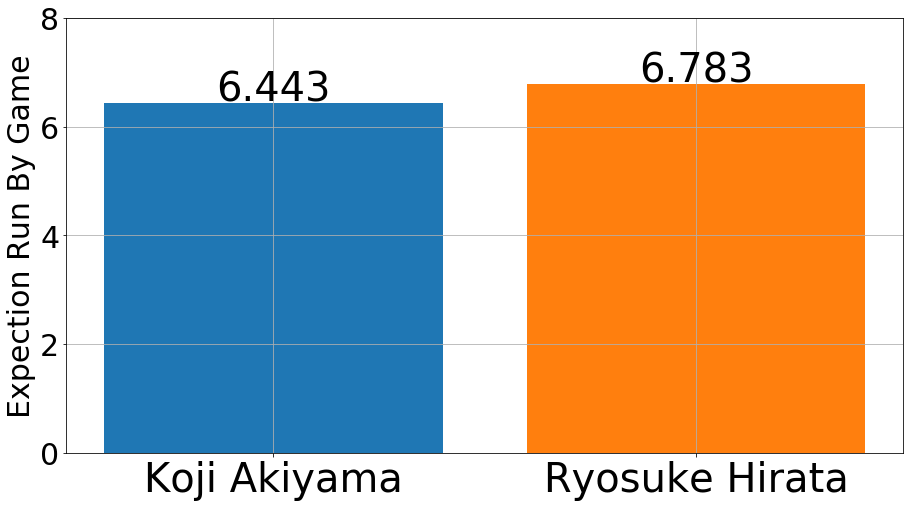

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.bar(0, ERBGs[0], label="Koji Akiyama")
ax.bar(1, ERBGs[1], label="Ryosuke Hirata")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Koji Akiyama", "Ryosuke Hirata"])
ax.grid()
ax.text(0, ERBGs[0]+0.04, s="{:.4}".format(ERBGs[0]), horizontalalignment='center', size=40)
ax.text(1, ERBGs[1]+0.04, s="{:.4}".format(ERBGs[1]), horizontalalignment='center', size=40)
ax.set_ylim(0, 8)
ax.set_ylabel("Expection Run By Game", fontsize=30)
ax.tick_params(axis="y", labelsize=30)
ax.tick_params(axis="x", labelsize=40)
plt.show()